In [1]:
import pandas as pd

import matplotlib.pyplot as plt


In [2]:
def get_discrimination (df, sensitive_attributes, class_name):

# ASSUMPTION: Each value of the attribute is discriminated
# For each value, we therefore apply the Preferential Sampling formulas to compute the discrimination 
# If discrimination > 0, the assumption holds true
# Otherwhise, it doesn't. This means the value is actually *privileged*
# A dictionary of sensitive attributes and values is created as such
#
# Please note the sum of records to add / remove for each priviliged value
# should be equal to the sum of records to add / removed for each discriminated value
#
# A rounding error is possible

    
    sensitive_dict = {}
    
    print ("Records:", len(df))
    
    tot_disc = 0
    tot_pos = 0
    
    #df = X_proba
    
    for attr in sensitive_attributes:
        print ()
        print ("Analizing", attr, "...")
        sensitive_dict[attr] = {}
        sensitive_dict[attr]['D'] = {}
        sensitive_dict[attr]['P'] = {}
        sensitive_dict[attr]['D']['values_list'] = []
        sensitive_dict[attr]['P']['values_list'] = []
        attribute_disc = 0
        values = df[attr].unique()
        for val in values:
            PP = df[(df[attr] != val) & (df[class_name] == 1)].values.tolist()
            PN = df[(df[attr] != val) & (df[class_name] == 0)].values.tolist()
            DP = df[(df[attr] == val) & (df[class_name] == 1)].values.tolist()
            DN = df[(df[attr] == val) & (df[class_name] == 0)].values.tolist()

            disc = len(DN) + len(DP)
            priv = len(PN) + len(PP)
            pos = len(PP) + len(DP)
            neg = len(PN) + len(DN)
            
            DP_exp = round(disc * pos / len(df))
            PP_exp = round(priv * pos / len(df))
            DN_exp = round(disc * neg / len(df))
            PN_exp = round(priv * neg / len(df))
            
            discrimination = len(PP) / (len(PP) + len(PN)) - len(DP) / (len(DP) + len(DN))
       
            if discrimination >= 0:
                status = 'D'
                sensitive_dict[attr][status][val] = {}
                print("")
                print(val, "is discriminated")
                print("Local disc:", discrimination)
                
                sensitive_dict[attr][status][val]['P'] = DP
                sensitive_dict[attr][status][val]['P_exp'] = DP_exp
                sensitive_dict[attr][status][val]['P_curr'] = 0
                
                #for i in range(len(sensitive_dict[attr][status][val]['P'])):
                   # del sensitive_dict[attr][status][val]['P'][i][-1]
                                
                sensitive_dict[attr][status][val]['N'] = DN[0]
                sensitive_dict[attr][status][val]['N_exp'] = DN_exp
                sensitive_dict[attr][status][val]['N_curr'] = 0
                sensitive_dict[attr][status][val]['GD'] = 100 * (abs(len(DP)-DP_exp) + abs(len(DN)-DN_exp)) / len(df)

                #for i in range(len(sensitive_dict[attr][status][val]['N'])):
                    #del sensitive_dict[attr][status][val]['N'][i][-1]
                    
                print("Global disc:", sensitive_dict[attr][status][val]['GD'])

                print("- DP:", len(sensitive_dict[attr][status][val]['P']), '· Expected:', DP_exp, 
                      '· To be added:', abs(len(DP) - DP_exp))
                print("- DN:", len(sensitive_dict[attr][status][val]['N']), '· Expected:', DN_exp, 
                      '· To be removed:', abs(len(DN) - DN_exp))
                
                tot_disc = tot_disc + abs(len(DP) - DP_exp)
                
                attribute_disc = attribute_disc + sensitive_dict[attr][status][val]['GD']
                

            else:
                status = 'P'
                sensitive_dict[attr][status][val] = {}
                print("")
                print(val, "is privileged:", discrimination)   
                
                sensitive_dict[attr][status][val]['P'] = DP
                sensitive_dict[attr][status][val]['P_exp'] = DP_exp
                sensitive_dict[attr][status][val]['P_curr'] = 0

                #for i in range(len(sensitive_dict[attr][status][val]['P'])):
                    #del sensitive_dict[attr][status][val]['P'][i][-1]
                    
                sensitive_dict[attr][status][val]['N'] = DN
                sensitive_dict[attr][status][val]['N_exp'] = DN_exp
                sensitive_dict[attr][status][val]['N_curr'] = 0
                sensitive_dict[attr][status][val]['GD'] = 100 * (abs(len(DP)-DP_exp) + abs(len(DN)-DN_exp)) / len(df)


                #for i in range(len(sensitive_dict[attr][status][val]['N'])):
                    #del sensitive_dict[attr][status][val]['N'][i][-1]
                    
                print("Global disc:", sensitive_dict[attr][status][val]['GD'])
                
                print("- PP:", len(sensitive_dict[attr][status][val]['P']), '· Expected:', DP_exp, 
                      '· To be removed:', abs(len(DP) - DP_exp))
                print("- PN:", len(sensitive_dict[attr][status][val]['N']), '· Expected:', DN_exp, 
                      '· To be added:', abs(len(DN) - DN_exp))
                
                tot_pos = tot_pos + abs(len(DP) - DP_exp)
            
            sensitive_dict[attr][status]['values_list'].append(val)
            
        print("")       
        print ("Global discrimination for", attr, attribute_disc)
        
        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = 'Discriminated, ' + str(round(attribute_disc, 2)) +"%", 'Non-discriminated'
        sizes = [attribute_disc, 100-attribute_disc]
        patches, texts = plt.pie(sizes, startangle=90)
        plt.legend(patches, labels, loc="best")
        # Set aspect ratio to be equal so that pie is drawn as a circle.
        plt.axis('equal')
        plt.tight_layout()
        plt.title("Global Discrimination for " + str(attr))
        plt.show()
        
        labels = []
        sizes = []
        
        for val in sensitive_dict[attr]['D']['values_list']:
            perc = sensitive_dict[attr]['D'][val]['GD']
            labels = labels + [f'{val}, {perc:0.1f}%']
            sizes = sizes + [perc]
        
        
        labels = labels + ['Unbiased']
        sizes = sizes + [100-sum(sizes)]
        patches, texts = plt.pie(sizes, startangle=90)
        plt.legend(patches, labels, loc="best")
        # Set aspect ratio to be equal so that pie is drawn as a circle.
        plt.axis('equal')
        plt.tight_layout()
        plt.title(attr + " privileged values")
        plt.show()

        labels = []
        sizes = []
        
        for val in sensitive_dict[attr]['P']['values_list']:
            perc = sensitive_dict[attr]['P'][val]['GD']
            labels = labels + [f'{val}, {perc:0.1f}%']
            sizes = sizes + [sensitive_dict[attr]['P'][val]['GD']]
        
        
        labels = labels + ['Unbiased']
        sizes = sizes + [100-sum(sizes)]
        patches, texts = plt.pie(sizes, startangle=90)
        plt.legend(patches, labels, loc="best")
        # Set aspect ratio to be equal so that pie is drawn as a circle.
        plt.axis('equal')
        plt.tight_layout()
        plt.title(attr + " discriminated values")
        plt.show()
        
            
            
        
    round_error = abs(tot_disc - tot_pos)

                                   
    return sensitive_dict            

In [3]:
df = pd.read_json("tesi_adult_train.json")

Records: 36177

Analizing race ...

4 is privileged: -0.1046926047724511
Global disc: 2.4988252204439285
- PP: 8180 · Expected: 7728 · To be removed: 452
- PN: 22984 · Expected: 23436 · To be added: 452

2 is discriminated
Local disc: 0.13551248924599507
Global disc: 2.2666334964203774
- DP: 417 · Expected: 827 · To be added: 410
- DN: 13 · Expected: 2510 · To be removed: 410

1 is privileged: -0.036606052992062016
Global disc: 0.20454985211598528
- PP: 296 · Expected: 259 · To be removed: 37
- PN: 748 · Expected: 785 · To be added: 37

3 is discriminated
Local disc: 0.13012280968035891
Global disc: 0.20454985211598528
- DP: 34 · Expected: 71 · To be added: 37
- DN: 13 · Expected: 215 · To be removed: 37

0 is discriminated
Local disc: 0.12197417452482051
Global disc: 0.23219172402355087
- DP: 44 · Expected: 86 · To be added: 42
- DN: 13 · Expected: 260 · To be removed: 42

Global discrimination for race 2.7033750725599135


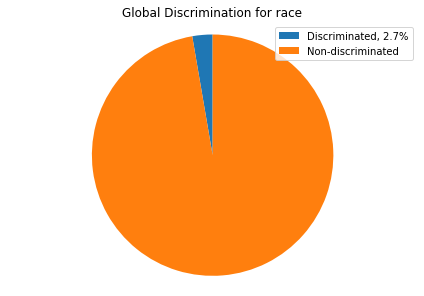

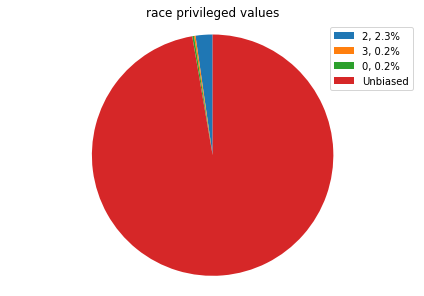

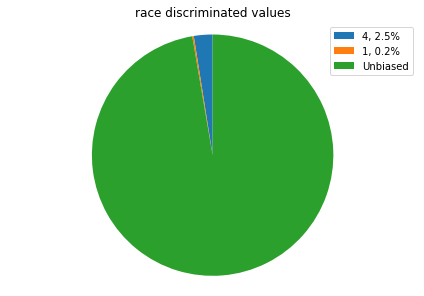


Analizing sex ...

1 is privileged: -0.1995855486064867
Global disc: 8.72930314840921
- PP: 7653 · Expected: 6074 · To be removed: 1579
- PN: 16843 · Expected: 18422 · To be added: 1579

0 is discriminated
Local disc: 0.1995855486064867
Global disc: 8.72930314840921
- DP: 1318 · Expected: 2897 · To be added: 1579
- DN: 13 · Expected: 8784 · To be removed: 1579

Global discrimination for sex 8.72930314840921


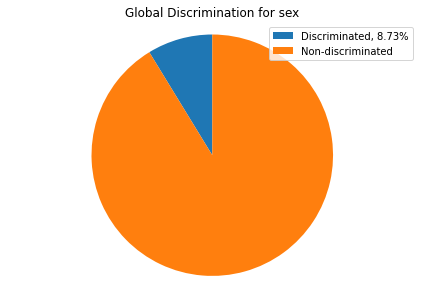

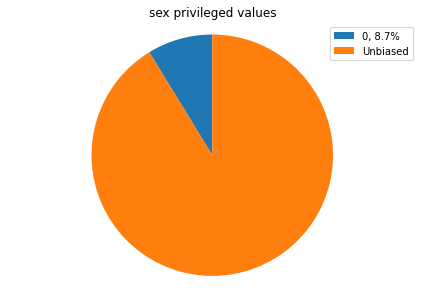

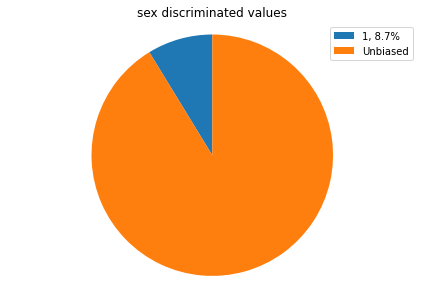

In [4]:
l = get_discrimination(df, ['race', 'sex'], 'income')